In [1]:
import logging
import time
from pathlib import Path

from delta.tables import DeltaTable
from pyspark.errors import PySparkException
from pyspark.sql import SparkSession


def query_delta_table(delta_path: str, filter_value: int, show_plan: bool = False) -> None:
    """
    Executa consulta otimizada em tabela Delta Lake com métricas seguras.
    """
    spark = None
    try:
        # Verificação da estrutura Delta
        delta_dir = Path(delta_path)
        if not (delta_dir.exists() and (delta_dir / "_delta_log").exists()):
            raise ValueError(f"Diretório Delta inválido: {delta_path}")

        spark = SparkSession.builder \
            .appName("DeltaQueryPro") \
            .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
            .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
            .config("spark.jars.packages", "io.delta:delta-spark_2.12:3.3.1") \
            .getOrCreate()

        # Coleta metadados de forma segura
        delta_table = DeltaTable.forPath(spark, delta_path)
        detail_df = delta_table.detail()

        # Colunas padrão disponíveis em todas versões
        table_format = detail_df.select("format").first()[0]
        size_mb = detail_df.select("sizeInBytes").first()[0] / (1024**2)
        partitions = detail_df.selectExpr("size(partitionColumns)").first()[0]

        print("\n" + "=" * 50)
        print("📊 METADADOS DA TABELA")
        print(f"Formato: {table_format}")
        print(f"Tamanho: {size_mb:.2f} MB")
        print(f"Partições: {partitions}")

        # Execução da consulta
        start_time = time.time()
        df = delta_table.toDF()
        result = df.filter(f"index = {filter_value}").cache()
        record_count = result.count()
        elapsed_time = time.time() - start_time

        print("\n" + "=" * 50)
        print("🚀 PERFORMANCE DA CONSULTA")
        print(f"Tempo: {elapsed_time:.4f}s")
        print(f"Registros: {record_count}")

        # if show_plan:
        #     print("\n" + "="*50)
        #     print("🔍 PLANO DE EXECUÇÃO")
        #     result.explain(extended=True)

        if record_count > 0:
            print("\n" + "=" * 50)
            print(f"✅ RESULTADOS PARA INDEX = {filter_value}")
            result.show(truncate=False, n=20)

    except PySparkException as e:
        logging.error(f"Erro Spark: {e!s}")
    except Exception as e:
        logging.error(f"Erro geral: {e!s}")
    finally:
        if spark:
            spark.stop()
            print("\n🔌 Conexão Spark encerrada")


# Exemplo de uso
if __name__ == "__main__":
    query_delta_table(
        delta_path="/Users/wilkne/Development/parquet-query/src/data/delta",
        filter_value=138998,
        show_plan=True
    )


:: loading settings :: url = jar:file:/Users/wilkne/Development/parquet-query/.venv/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/wilkne/.ivy2/cache
The jars for the packages stored in: /Users/wilkne/.ivy2/jars
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-31a1a599-b4f7-41fa-858b-de2f0bbcc4e9;1.0
	confs: [default]
	found io.delta#delta-spark_2.12;3.3.1 in central
	found io.delta#delta-storage;3.3.1 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 137ms :: artifacts dl 5ms
	:: modules in use:
	io.delta#delta-spark_2.12;3.3.1 from central in [default]
	io.delta#delta-storage;3.3.1 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   


📊 METADADOS DA TABELA
Formato: delta
Tamanho: 216.81 MB
Partições: 0



🚀 PERFORMANCE DA CONSULTA
Tempo: 2.0966s
Registros: 31

✅ RESULTADOS PARA INDEX = 138998
+------+----------+-------------------+-----------------------------+--------------------------------------------------+------------------------------------------+------------------------------------------+---------------------+--------------------------------------+---------------------------------+------------------------------------+------------------------------------+-----------------------------------------+-----------------------------------------+-------------------------------+-------------------------------+------------------------------+---------------------------+-----------------------+----------------------------+------+-----+--------------------------------+------------+------------+------------+------+
|index |Data      |Hora               |PRECIPITACAO_TOTAL_HORARIO_mm|PRESSAO_ATMOSFERICA_AO_NIVEL_DA_ESTACAO_HORARIA_mB|PRESSAO_ATMOSFERICA_MAX_NA_HORA_ANT_AUT_mB|PRESSAO_ATMOSFERICA

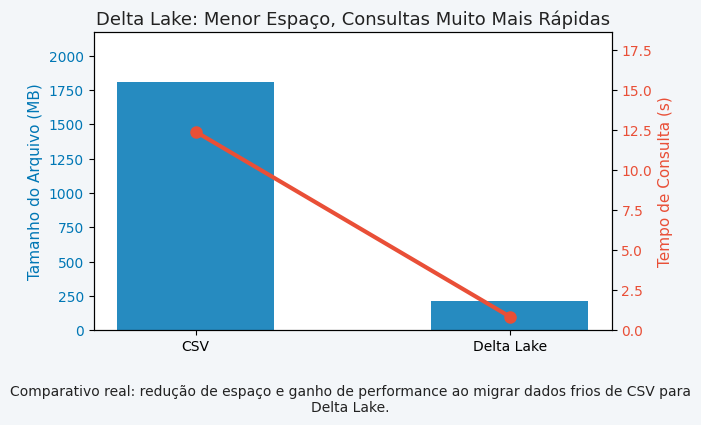

In [2]:
import matplotlib.pyplot as plt

# Dados
formatos = ['CSV', 'Delta Lake']
tamanhos_mb = [1807.74, 216.81]
tempos_s = [12.4, 0.86]

# Cores LinkedIn-friendly
azul_linkedin = "#0077B5"
cinza_claro = "#F3F6F9"
vermelho = "#E94F37"

fig, ax1 = plt.subplots(figsize=(7, 4), facecolor=cinza_claro)

# Barras para tamanho
ax1.bar(formatos, tamanhos_mb, color=azul_linkedin, width=0.5, alpha=0.85)
ax1.set_ylabel('Tamanho do Arquivo (MB)', color=azul_linkedin, fontsize=11)
ax1.tick_params(axis='y', labelcolor=azul_linkedin)
ax1.set_ylim(0, max(tamanhos_mb) * 1.2)

# Linha para tempo de consulta
ax2 = ax1.twinx()
ax2.plot(formatos, tempos_s, color=vermelho, marker='o', linewidth=3, markersize=8, label='Tempo de Consulta (s)')
ax2.set_ylabel('Tempo de Consulta (s)', color=vermelho, fontsize=11)
ax2.tick_params(axis='y', labelcolor=vermelho)
ax2.set_ylim(0, max(tempos_s) * 1.5)

# Título e detalhes visuais
plt.title('Delta Lake: Menor Espaço, Consultas Muito Mais Rápidas', fontsize=13, color="#222")
fig.tight_layout(pad=2)
fig.patch.set_facecolor(cinza_claro)

# Texto explicativo
plt.figtext(0.5, -0.07,
    "Comparativo real: redução de espaço e ganho de performance ao migrar dados frios de CSV para Delta Lake.",
    wrap=True, horizontalalignment='center', fontsize=10, color="#222")

plt.show()
